## Python Libraries

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import timm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Loading Dataset

In [ ]:
# Define the path to your dataset
data_dir = 'lung_colon_image_set\lung_image_sets'

In [ ]:
# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

In [ ]:
# Create a dataset object
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
# Create a DataLoader to efficiently load and batch the data
batch_size = 32
original_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Pre-processing Data and creating a New Dataset

In [ ]:
def preprocess_dataset(dataset, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for image_path, label in dataset.imgs:
        # Step 1: Convert RGB to LAB
        original_image = cv2.imread(image_path)
        lab_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2LAB)

        # Step 2: Binary Thresholding
        _, binary_mask = cv2.threshold(lab_image[:, :, 0], 127, 255, cv2.THRESH_BINARY)

        # Step 3: Cleaning methods and mask generation
        kernel = np.ones((5, 5), np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

        # Step 4: Mask application on the RGB original image
        result_image = cv2.bitwise_and(original_image, original_image, mask=binary_mask)

        # Get class name
        class_name = dataset.classes[label]

        # Create subdirectory for the current class
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # Save preprocessed image in the class-specific directory
        filename = os.path.basename(image_path)
        output_path = os.path.join(class_output_dir, filename)
        cv2.imwrite(output_path, result_image)

In [ ]:
# Apply preprocessing function to the entire dataset
preprocessed_data_dir = 'PDataset'
preprocessed_images = preprocess_dataset(dataset, preprocessed_data_dir)

In [ ]:
def get_sample_indices(dataset):
    class_indices = {class_name: [] for class_name in dataset.classes}
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[dataset.classes[label]].append(idx)

    sample_indices = {class_name: np.random.choice(indices, 1)[0] for class_name, indices in class_indices.items()}
    return sample_indices

In [ ]:
def plot_sample_images(dataset, sample_indices):
    for class_name, idx in sample_indices.items():
        original_image_path, label = dataset.samples[idx]
        original_image = cv2.imread(original_image_path)

        preprocessed_image_path = os.path.join(preprocessed_data_dir, class_name, os.path.basename(original_image_path))
        preprocessed_image = cv2.imread(preprocessed_image_path)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f'Original - Class: {class_name}')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f'Preprocessed - Class: {class_name}')
        axs[1].axis('off')

        plt.show()

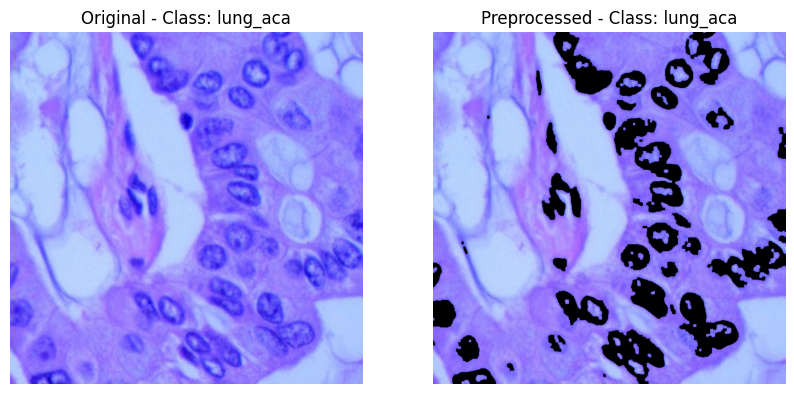

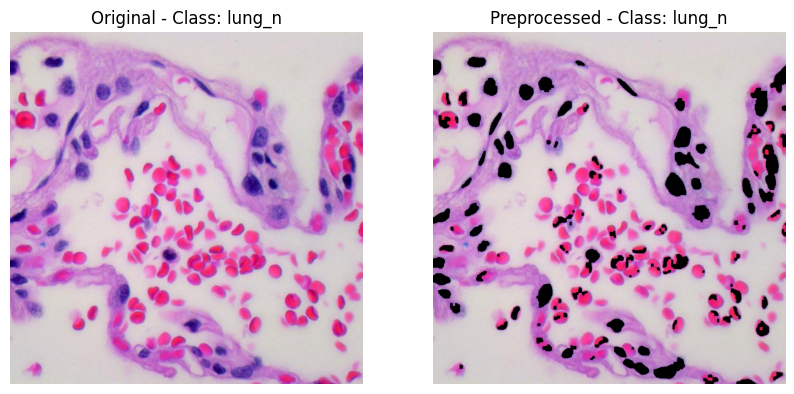

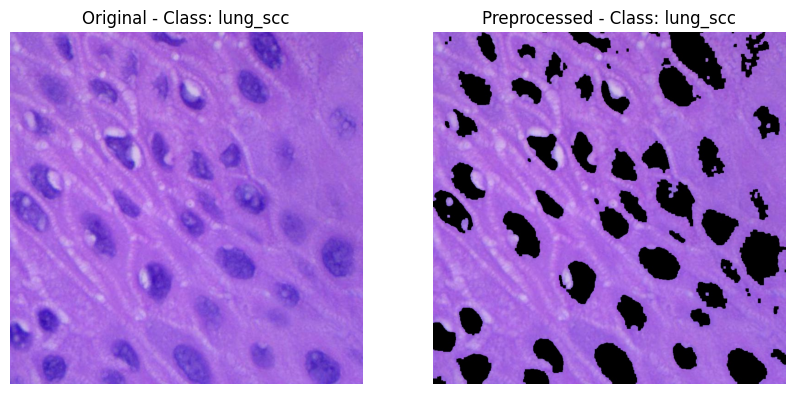

In [ ]:
# Get sample indices for each class
sample_indices = get_sample_indices(dataset)

# Plot sample images for each class
plot_sample_images(dataset, sample_indices)

## Feature Extraction using Vision Transformers

In [ ]:
# Create a dataset object for the Preprocessed dataset
preprocessed_data_dir = 'PDataset'
Pdataset = datasets.ImageFolder(root=preprocessed_data_dir, transform=transform)

In [ ]:
# Get the number of classes in the dataset
num_classes = len(Pdataset.classes)

In [ ]:
# Set the number of samples to load for each class
samples_per_class = 1000

In [ ]:
# Initialize a list to store sampled indices
sampled_indices = []

In [ ]:
# Iterate through each class and randomly sample indices
for class_idx in range(num_classes):
    class_indices = [idx for idx, (_, label) in enumerate(Pdataset.imgs) if label == class_idx]
    sampled_indices.extend(np.random.choice(class_indices, min(samples_per_class, len(class_indices)), replace=False))

In [ ]:
# Create a DataLoader with the sampled indices
batch_size = 32
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(Pdataset, sampled_indices),
    #Pdataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# Load a pre-trained Vision Transformer model (e.g., ViT-B/16)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model.eval()

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Simhadri Kushal\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Feature extraction using Vision Transformer
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in original_data_loader:
        features = vit_model(images)
        all_features.append(features)
        all_labels.append(labels)

all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

In [ ]:
# Convert the list of features to a numpy array
features = np.array(all_features)

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


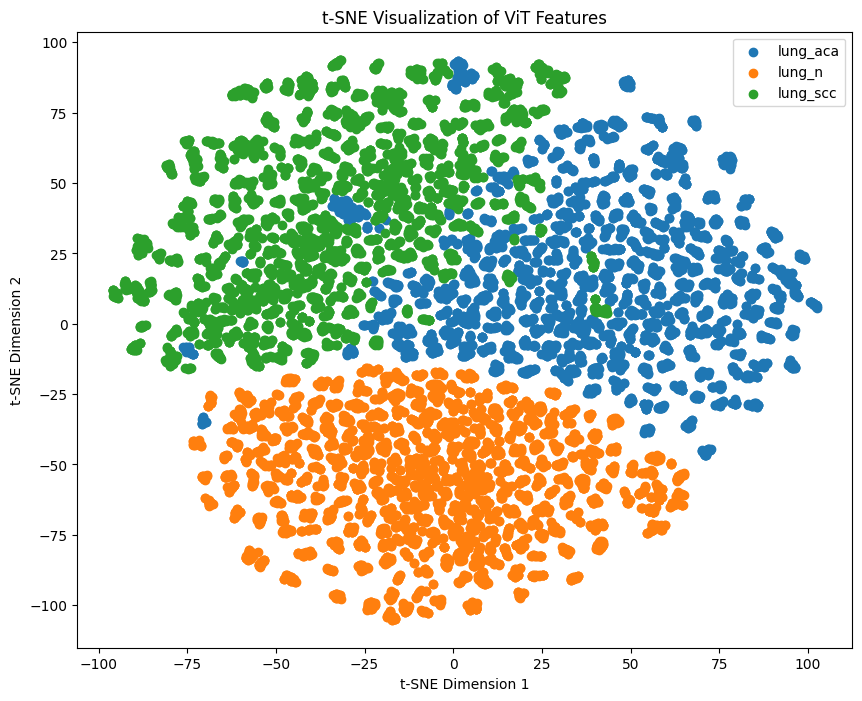

In [ ]:
from sklearn.manifold import TSNE

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(all_features)

# Visualize t-SNE features
plt.figure(figsize=(10, 8))
for class_idx, class_name in enumerate(Pdataset.classes):
    class_indices = (all_labels == class_idx)
    plt.scatter(features_tsne[class_indices, 0], features_tsne[class_indices, 1], label=class_name)

plt.title('t-SNE Visualization of ViT Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

## Applying Pre-trained Models

In [ ]:
# Calculate the size of the training and testing sets
total_size = len(data_loader.dataset)
train_size = int(0.8 * total_size)  # 80% for training, adjust as needed
test_size = total_size - train_size

In [ ]:
train_set, test_set = random_split(data_loader.dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
def train_model(model, train_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Move model to the device
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")

In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    true_positives, false_positives, true_negatives, false_negatives = 0, 0, 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    epsilon = 1e-7
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)


    print(classification_report(all_labels, all_predictions))

    return accuracy, precision, recall, f1_score

### AlexNet Model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import time

In [ ]:
# Load a pretrained AlexNet model
alexnet_model = models.alexnet(pretrained=True)
alexnet_model.classifier[6] = nn.Linear(4096, 3)

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
start_time = time.time()
train_model(alexnet_model, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/30], Loss: 0.8014
Epoch [2/30], Loss: 0.7455
Epoch [3/30], Loss: 0.6450
Epoch [4/30], Loss: 0.5698
Epoch [5/30], Loss: 0.5558
Epoch [6/30], Loss: 0.5452
Epoch [7/30], Loss: 0.5444
Epoch [8/30], Loss: 0.7368
Epoch [9/30], Loss: 1.0501
Epoch [10/30], Loss: 1.1027
Epoch [11/30], Loss: 1.1014
Epoch [12/30], Loss: 1.1019
Epoch [13/30], Loss: 1.1004
Epoch [14/30], Loss: 1.0998
Epoch [15/30], Loss: 1.1001
Epoch [16/30], Loss: 1.0988
Epoch [17/30], Loss: 1.0989
Epoch [18/30], Loss: 1.0989
Epoch [19/30], Loss: 1.0992
Epoch [20/30], Loss: 1.0993
Epoch [21/30], Loss: 1.0987
Epoch [22/30], Loss: 1.0992
Epoch [23/30], Loss: 1.0989
Epoch [24/30], Loss: 1.0992
Epoch [25/30], Loss: 1.0994
Epoch [26/30], Loss: 1.0990
Epoch [27/30], Loss: 1.0990
Epoch [28/30], Loss: 1.0990
Epoch [29/30], Loss: 1.0989
Epoch [30/30], Loss: 1.0990
Training complete.
Total training time: 5065.693 seconds


In [ ]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model.to(device) 

accuracy, precision, recall, f1_score = evaluate_model(alexnet_model, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

AssertionError: Torch not compiled with CUDA enabled

### VGG Model

In [ ]:
vgg16_model = models.vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(4096, 3)  # Adjusting for 3 classes

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
start_time = time.time()
train_model(vgg16_model, train_loader, num_epochs=10)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/10], Loss: 1.2158
Epoch [2/10], Loss: 1.0862
Epoch [3/10], Loss: 4.0432
Epoch [4/10], Loss: 1.1006
Epoch [5/10], Loss: 1.1010
Epoch [6/10], Loss: 1.1040
Epoch [7/10], Loss: 1.1046
Epoch [8/10], Loss: 1.1022
Epoch [9/10], Loss: 1.1022
Epoch [10/10], Loss: 1.1031
Training complete.
Total training time: 7310.848 seconds


In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(vgg16_model, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.00      0.00      0.00       203
           2       0.33      1.00      0.50       198

    accuracy                           0.33       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.33      0.16       600

Accuracy: 0.3300, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### GoogLeNet Model

In [ ]:
googlenet_model = models.googlenet(pretrained=True)
googlenet_model.fc = nn.Linear(1024, 3)  # Adjusting for 3 classes

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
start_time = time.time()
train_model(googlenet_model, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/30], Loss: 0.2381
Epoch [2/30], Loss: 0.1020
Epoch [3/30], Loss: 0.1098
Epoch [4/30], Loss: 0.0893
Epoch [5/30], Loss: 0.0356
Epoch [6/30], Loss: 0.0315
Epoch [7/30], Loss: 0.0492
Epoch [8/30], Loss: 0.0333
Epoch [9/30], Loss: 0.0477
Epoch [10/30], Loss: 0.0402
Epoch [11/30], Loss: 0.0269
Epoch [12/30], Loss: 0.0043
Epoch [13/30], Loss: 0.0035
Epoch [14/30], Loss: 0.0022
Epoch [15/30], Loss: 0.0650
Epoch [16/30], Loss: 0.0733
Epoch [17/30], Loss: 0.0120
Epoch [18/30], Loss: 0.0101
Epoch [19/30], Loss: 0.0210
Epoch [20/30], Loss: 0.0408
Epoch [21/30], Loss: 0.0219
Epoch [22/30], Loss: 0.0229
Epoch [23/30], Loss: 0.0224
Epoch [24/30], Loss: 0.0080
Epoch [25/30], Loss: 0.0089
Epoch [26/30], Loss: 0.0141
Epoch [27/30], Loss: 0.0228
Epoch [28/30], Loss: 0.0538
Epoch [29/30], Loss: 0.0091
Epoch [30/30], Loss: 0.0039
Training complete.
Total training time: 7045.449 seconds


In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(googlenet_model, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       199
           1       1.00      0.99      1.00       203
           2       0.91      0.98      0.94       198

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

Accuracy: 0.9583, Precision: 1.0000, Recall: 0.9901, F1 Score: 0.9950


### ResNet Model

In [ ]:
resnet_model = models.resnet18(pretrained=True)

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
start_time = time.time()
train_model(resnet_model, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/30], Loss: 0.5128
Epoch [2/30], Loss: 0.1447
Epoch [3/30], Loss: 0.1410
Epoch [4/30], Loss: 0.0997
Epoch [5/30], Loss: 0.1070
Epoch [6/30], Loss: 0.0642
Epoch [7/30], Loss: 0.0290
Epoch [8/30], Loss: 0.0517
Epoch [9/30], Loss: 0.0353
Epoch [10/30], Loss: 0.0995
Epoch [11/30], Loss: 0.0467
Epoch [12/30], Loss: 0.0330
Epoch [13/30], Loss: 0.0168
Epoch [14/30], Loss: 0.0376
Epoch [15/30], Loss: 0.0623
Epoch [16/30], Loss: 0.0133
Epoch [17/30], Loss: 0.0042
Epoch [18/30], Loss: 0.0022
Epoch [19/30], Loss: 0.0015
Epoch [20/30], Loss: 0.0013
Epoch [21/30], Loss: 0.0015
Epoch [22/30], Loss: 0.0018
Epoch [23/30], Loss: 0.0575
Epoch [24/30], Loss: 0.0577
Epoch [25/30], Loss: 0.0623
Epoch [26/30], Loss: 0.0114
Epoch [27/30], Loss: 0.0443
Epoch [28/30], Loss: 0.0159
Epoch [29/30], Loss: 0.0121
Epoch [30/30], Loss: 0.0063
Training complete.
Total training time: 2073.555 seconds


In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(resnet_model, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       199
           1       1.00      1.00      1.00       203
           2       0.92      0.93      0.93       198

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Accuracy: 0.9483, Precision: 0.9951, Recall: 0.9951, F1 Score: 0.9951


### DenseNet Model

In [ ]:
from torchvision import models
densenet_model = models.densenet121(pretrained=True)

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Replace the classifier to match the number of classes (3 in your case)
num_ftrs = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_ftrs, 3)

In [ ]:
start_time = time.time()
train_model(densenet_model, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/30], Loss: 0.2674
Epoch [2/30], Loss: 0.1418
Epoch [3/30], Loss: 0.1080
Epoch [4/30], Loss: 0.0917
Epoch [5/30], Loss: 0.0821
Epoch [6/30], Loss: 0.0617
Epoch [7/30], Loss: 0.0659
Epoch [8/30], Loss: 0.0304
Epoch [9/30], Loss: 0.0428
Epoch [10/30], Loss: 0.0309
Epoch [11/30], Loss: 0.1386
Epoch [12/30], Loss: 0.0371
Epoch [13/30], Loss: 0.0231
Epoch [14/30], Loss: 0.0268
Epoch [15/30], Loss: 0.0340
Epoch [16/30], Loss: 0.0295
Epoch [17/30], Loss: 0.0076
Epoch [18/30], Loss: 0.0035
Epoch [19/30], Loss: 0.0031
Epoch [20/30], Loss: 0.0066
Epoch [21/30], Loss: 0.0379
Epoch [22/30], Loss: 0.0639
Epoch [23/30], Loss: 0.0522
Epoch [24/30], Loss: 0.0173
Epoch [25/30], Loss: 0.0088
Epoch [26/30], Loss: 0.0009
Epoch [27/30], Loss: 0.0012
Epoch [28/30], Loss: 0.0241
Epoch [29/30], Loss: 0.0452
Epoch [30/30], Loss: 0.0255
Training complete.
Total training time: 7579.029 seconds


In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(densenet_model, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       193
           1       0.99      1.00      1.00       188
           2       0.98      0.94      0.96       219

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Accuracy: 0.9683, Precision: 0.9947, Recall: 1.0000, F1 Score: 0.9973


## Custom CNN Model

### Simple Custom CNN

In [ ]:
# Adjusting the custom CNN model according to the train_model() function requirements
# and also considering the output of the final convolutional layer to match the input
# of the first fully connected layer.

class CustomCNNAdjusted(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNNAdjusted, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(p=0.25)
        
        # Adaptive pooling layer
        self.adapt_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.adapt_pool(x)
        x = x.view(-1, 128 * 7 * 7)  # Flatten the output for the fully connected layer
        x = self.drop(x)
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Create an instance of the adjusted model
CustomModel = CustomCNNAdjusted(num_classes=3)

# Display the adjusted model architecture
CustomModel

CustomCNNAdjusted(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
start_time = time.time()
train_model(CustomModel, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(CustomModel, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

### Custom CNN with Regularization

In [ ]:
class CustomCNNWithRegularization(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNNWithRegularization, self).__init__()
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(p=0.25)
        
        # Adaptive pooling layer
        self.adapt_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.drop_fc = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(-1, 128 * 7 * 7)  # Flatten the output for the fully connected layer
        x = self.drop(x)
        x = self.drop_fc(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create an instance of the adjusted model with regularization
model_reg = CustomCNNWithRegularization(num_classes=3)

# print the model architecture
model_reg

CustomCNNWithRegularization(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (drop_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
start_time = time.time()
train_model(model_reg, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

Epoch [1/30], Loss: 0.5152
Epoch [2/30], Loss: 0.3882
Epoch [3/30], Loss: 0.3313
Epoch [4/30], Loss: 0.2477
Epoch [5/30], Loss: 0.2141
Epoch [6/30], Loss: 0.2112
Epoch [7/30], Loss: 0.1715
Epoch [8/30], Loss: 0.1571
Epoch [9/30], Loss: 0.2006
Epoch [10/30], Loss: 0.1830
Epoch [11/30], Loss: 0.1322
Epoch [12/30], Loss: 0.1230
Epoch [13/30], Loss: 0.0914
Epoch [14/30], Loss: 0.0844
Epoch [15/30], Loss: 0.0947
Epoch [16/30], Loss: 0.1281
Epoch [17/30], Loss: 0.1035
Epoch [18/30], Loss: 0.0827
Epoch [19/30], Loss: 0.0899
Epoch [20/30], Loss: 0.0899
Epoch [21/30], Loss: 0.0685
Epoch [22/30], Loss: 0.0555
Epoch [23/30], Loss: 0.0456
Epoch [24/30], Loss: 0.0419
Epoch [25/30], Loss: 0.0445
Epoch [26/30], Loss: 0.0349
Epoch [27/30], Loss: 0.0394
Epoch [28/30], Loss: 0.0728
Epoch [29/30], Loss: 0.1298
Epoch [30/30], Loss: 0.2241
Training complete.
Total training time: 1265.976 seconds


In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(model_reg, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       200
           1       1.00      0.96      0.98       194
           2       0.91      0.93      0.92       206

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Accuracy: 0.9300, Precision: 1.0000, Recall: 0.9588, F1 Score: 0.9789


### EfficientNet Like Custom CNN

In [ ]:
class EfficientNetLike(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNetLike, self).__init__()
        # Define a simple EfficientNet-like block using depthwise separable convolutions
        def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=groups, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU6(inplace=True),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )
        
        # Stacking blocks
        self.layer1 = conv_block(3, 32, kernel_size=3, stride=1, padding=1, groups=3)
        self.layer2 = conv_block(32, 64, kernel_size=3, stride=2, padding=1, groups=32)
        self.layer3 = conv_block(64, 128, kernel_size=3, stride=2, padding=1, groups=64)
        
        # Adaptive pooling followed by a fully connected layer
        self.adapt_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Create an instance of the adjusted model with regularization
model_efficientNet = EfficientNetLike(num_classes=3)

# print the model architecture
model_efficientNet

In [ ]:
start_time = time.time()
train_model(model_efficientNet, train_loader, num_epochs=30)
end_time = time.time()  
total_time = end_time - start_time
print(f'Total training time: {total_time:.3f} seconds')

In [ ]:
accuracy, precision, recall, f1_score = evaluate_model(model_efficientNet, val_loader)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

## HyperTuing for Custom CNN Model

#### GridSearch for Learning Rate and BatchSize

In [ ]:
import itertools
import pandas as pd

In [ ]:
# Define the grid of hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32]

In [ ]:
# Initialize lists to store results
results = []
num_epochs = 10

In [ ]:
# Loop through all combinations
for learning_rate, batch_size in itertools.product(learning_rates, batch_sizes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a new instance of the model for each combination
    model = CustomCNNWithRegularization(num_classes=3)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Move model to the device
    model.to(device)

    # Create data loaders with the current batch size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Print the current hyperparameters
    print(f"\nTraining with learning rate: {learning_rate}, batch size: {batch_size}")

    # Evaluate the model
    accuracy, precision, recall, f1_score = evaluate_model(model, val_loader)

    # Store the results in a dictionary
    result_dict = {
        'Learning Rate': learning_rate,
        'Batch Size': batch_size,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    # Append the dictionary to the results list
    results.append(result_dict)

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

Epoch [1/10], Loss: 0.8267
Epoch [2/10], Loss: 0.4702
Epoch [3/10], Loss: 0.3960
Epoch [4/10], Loss: 0.4593
Epoch [5/10], Loss: 0.4090
Epoch [6/10], Loss: 0.3937
Epoch [7/10], Loss: 0.3048
Epoch [8/10], Loss: 0.3210
Epoch [9/10], Loss: 0.3011
Epoch [10/10], Loss: 0.3108

Training with learning rate: 0.001, batch size: 8
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       200
           1       0.96      0.98      0.97       194
           2       0.83      0.90      0.86       206

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Accuracy: 0.8917, Precision: 0.9845, Recall: 0.9845, F1 Score: 0.9845
Epoch [1/10], Loss: 0.6253
Epoch [2/10], Loss: 0.4305
Epoch [3/10], Loss: 0.3843
Epoch [4/10], Loss: 0.3113
Epoch [5/10], Loss: 0.2921
Epoch [6/10], Loss: 0.3030
Epoch [7/10], Loss: 0.3519
Epoch [8/10], Loss: 0.2701
Epoch [9/10

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       200
           1       0.00      0.00      0.00       194
           2       0.00      0.00      0.00       206

    accuracy                           0.33       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.33      0.17       600

Accuracy: 0.3333, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch [1/10], Loss: 265.1001
Epoch [2/10], Loss: 0.8383
Epoch [3/10], Loss: 0.7159
Epoch [4/10], Loss: 0.5692
Epoch [5/10], Loss: 0.6727
Epoch [6/10], Loss: 0.6684
Epoch [7/10], Loss: 0.7864
Epoch [8/10], Loss: 0.6973
Epoch [9/10], Loss: 0.7940
Epoch [10/10], Loss: 0.8173

Training with learning rate: 0.1, batch size: 16
              precision    recall  f1-score   support

           0       0.54      0.98      0.69       200
           1       1.00      0.90      0.95       194
           2       0.95      0.27      0.42       206

    accu

c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Simhadri Kushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [ ]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results in tabular form
print("\nResults Summary:")
print(results_df)


Results Summary:
   Learning Rate  Batch Size  Accuracy  Precision    Recall  F1 Score
0          0.001           8  0.891667   0.984536  0.984536  0.984536
1          0.001          16  0.886667   0.974747  0.994845  0.984694
2          0.001          32  0.910000   1.000000  0.979381  0.989583
3          0.010           8  0.886667   0.989247  0.948454  0.968421
4          0.010          16  0.821667   0.989247  0.948454  0.968421
5          0.010          32  0.758333   0.989189  0.943299  0.965699
6          0.100           8  0.333333   0.000000  0.000000  0.000000
7          0.100          16  0.711667   1.000000  0.896907  0.945652
8          0.100          32  0.650000   0.989247  1.000000  0.994595


#### K-Fold Cross Validaition

In [ ]:
# Create a DataLoader with the sampled indices
batch_size = 32
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(Pdataset, sampled_indices),
    #Pdataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# Split the dataset into training and validation sets
total_size = len(data_loader.dataset)
train_size = int(0.8 * total_size)  # 80% for training, adjust as needed
test_size = total_size - train_size
train_dataset, val_dataset =  random_split(data_loader.dataset, [train_size, test_size])

In [ ]:
def train_model_K_fold(model, train_loader, optimizer, criterion, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")


In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    correct = 0
    total = 0
    true_positives = false_positives = true_negatives = false_negatives = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update metrics for binary classification
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    precision = true_positives / (true_positives + false_positives + 1e-7)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return accuracy, precision, recall, f1_score


In [ ]:
# Initialize lists to track per-fold performance
fold_accuracies, fold_precisions, fold_recalls, fold_f1_scores = [], [], [], []

In [ ]:
k_folds = 10
batch_size = 32
num_epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

NameError: name 'KFold' is not defined

In [ ]:
for fold, (train_indices, val_indices) in enumerate(kf.split(data_loader.dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(data_loader.dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(data_loader.dataset, batch_size=batch_size, sampler=val_sampler)

    model = CustomCNNWithRegularization(num_classes=3).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_model_K_fold(model, train_loader, optimizer, criterion, num_epochs)

    # Evaluate the model
    accuracy, precision, recall, f1_score = evaluate_model(model, val_loader, device)

    # Append results for the current fold
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    print(f"Fold {fold + 1}: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}\n")

# Calculate average metrics over all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
average_precision = sum(fold_precisions) / len(fold_precisions)
average_recall = sum(fold_recalls) / len(fold_recalls)
average_f1_score = sum(fold_f1_scores) / len(fold_f1_scores)

print(f"Average Metrics Across {k_folds} folds: Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}, Recall: {average_recall:.4f}, F1 Score: {average_f1_score:.4f}")

FOLD 0
--------------------------------
Epoch [1/30], Loss: 0.5111
Epoch [2/30], Loss: 0.3412
Epoch [3/30], Loss: 0.2901
Epoch [4/30], Loss: 0.2724
Epoch [5/30], Loss: 0.2877
Epoch [6/30], Loss: 0.2566
Epoch [7/30], Loss: 0.2316
Epoch [8/30], Loss: 0.2577
Epoch [9/30], Loss: 0.2101
Epoch [10/30], Loss: 0.1459
Epoch [11/30], Loss: 0.1525
Epoch [12/30], Loss: 0.1468
Epoch [13/30], Loss: 0.1020
Epoch [14/30], Loss: 0.0919
Epoch [15/30], Loss: 0.1128
Epoch [16/30], Loss: 0.1451
Epoch [17/30], Loss: 0.1021
Epoch [18/30], Loss: 0.1148
Epoch [19/30], Loss: 0.1358
Epoch [20/30], Loss: 0.0767
Epoch [21/30], Loss: 0.1381
Epoch [22/30], Loss: 0.1351
Epoch [23/30], Loss: 0.1202
Epoch [24/30], Loss: 0.0911
Epoch [25/30], Loss: 0.0516
Epoch [26/30], Loss: 0.0412
Epoch [27/30], Loss: 0.0584
Epoch [28/30], Loss: 0.0294
Epoch [29/30], Loss: 0.1484
Epoch [30/30], Loss: 0.0860
Training complete.
Fold 1: Accuracy: 0.9500, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

FOLD 1
------------------------

In [ ]:
# Calculate average metrics over all folds
average_accuracy = sum(fold_accuracies) / k_folds
average_precision = sum(fold_precisions) / k_folds
average_recall = sum(fold_recalls) / k_folds
average_f1_score = sum(fold_f1_scores) / k_folds

In [ ]:
# Display the average results
print("\nAverage Results:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1_score:.4f}")


Average Results:
Average Accuracy: 0.9493
Average Precision: 0.9948
Average Recall: 0.9919
Average F1 Score: 0.9933


In [ ]:
'''
import os
import shutil
import random

# Replace these paths with your actual paths
source_directory = "ALL Dataset"
destination_directory = "d1"

# Create D1 directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# List all classes in the source directory
classes = os.listdir(source_directory)

# Number of images to transfer from each patient
num_images_to_transfer = 25

# Loop through each class
for class_name in classes:
    # Create a folder for the current class in D1
    class_destination = os.path.join(destination_directory, class_name)
    os.makedirs(class_destination, exist_ok=True)

    # List all patients in the current class
    patients = os.listdir(os.path.join(source_directory, class_name))

    # Loop through each patient
    for patient_name in patients:
        # Create a folder for the current patient in the D1 class
        patient_destination = os.path.join(class_destination, patient_name)
        os.makedirs(patient_destination, exist_ok=True)

        # List all images in the current patient folder
        images = os.listdir(os.path.join(source_directory, class_name, patient_name))

        # Transfer random images to the D1 folder
        selected_images = random.sample(images, min(num_images_to_transfer, len(images)))
        for image in selected_images:
            source_path = os.path.join(source_directory, class_name, patient_name, image)
            destination_path = os.path.join(patient_destination, image)
            shutil.copy2(source_path, destination_path)

print("Images transferred successfully.")
'''

'\nimport os\nimport shutil\nimport random\n\n# Replace these paths with your actual paths\nsource_directory = "ALL Dataset"\ndestination_directory = "d1"\n\n# Create D1 directory if it doesn\'t exist\nif not os.path.exists(destination_directory):\n    os.makedirs(destination_directory)\n\n# List all classes in the source directory\nclasses = os.listdir(source_directory)\n\n# Number of images to transfer from each patient\nnum_images_to_transfer = 25\n\n# Loop through each class\nfor class_name in classes:\n    # Create a folder for the current class in D1\n    class_destination = os.path.join(destination_directory, class_name)\n    os.makedirs(class_destination, exist_ok=True)\n\n    # List all patients in the current class\n    patients = os.listdir(os.path.join(source_directory, class_name))\n\n    # Loop through each patient\n    for patient_name in patients:\n        # Create a folder for the current patient in the D1 class\n        patient_destination = os.path.join(class_destina